In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import json
from pprint import pprint

Change `json_path` here

In [2]:
json_path="./scalingGraph.json"

In [3]:
with open(json_path) as f:
    data = json.load(f)
timings = []
for d in data["datapoints"]:
    s = d["setting"]
    comp = list(map(lambda x: (x["computationTime"]),
                   sorted(d["data"]["workers"], key=lambda x: x["rank"])))
    comp = max(comp)
    mpi = list(map(lambda x: (x["mpiTime"]),
                   sorted(d["data"]["workers"], key=lambda x: x["rank"])))
    mpi = max(mpi)
    timings.append((comp, mpi, s["nodeCount"]))


print(len(timings), timings)

20 [(112947472, 437463, 2), (86905767, 2198746, 4), (78449806, 15541560, 6), (56323385, 6866612, 8), (59353368, 23385577, 10), (50845865, 5880008, 12), (39842227, 6333247, 14), (36293879, 6143928, 16), (35515185, 15535714, 18), (36269501, 7179025, 20), (20629578, 7111682, 22), (24823994, 7091540, 24), (20616056, 26449197, 26), (24083707, 6649373, 28), (19874740, 8289929, 30), (24179422, 7012762, 32), (20633102, 13843912, 34), (16397577, 6989272, 36), (20630870, 17910987, 38), (17827285, 6960380, 40)]


In [4]:
cpT, mpiT, nodeCnt = zip(*timings)

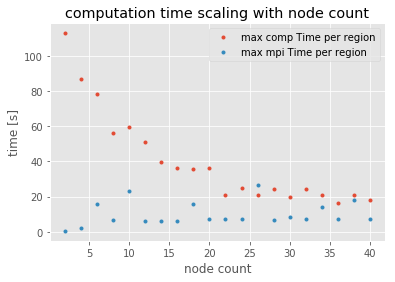

In [5]:
plt.style.use('ggplot')

x = np.asarray(nodeCnt)
#  time in s
cp = np.asarray(cpT) / 1e6
mpi = np.asarray(mpiT) / 1e6


fig, host = plt.subplots()
# par1 = host.twinx()

host.plot(x, cp, label="max comp Time per region", lw=0, marker=".")
host.plot(x, mpi, label="max mpi Time per region", lw=0, marker=".")

host.set(xlabel='node count', ylabel='time [s]',
    title='computation time scaling with node count'
)
# par1.set(ylabel='max mpi time [s]')

host.legend()
host.grid(True)
#plt.axis([0, None, 0, 0.04])

fig.savefig("scaling_graph.svg", format="svg")
plt.show()

**TODO:** Add regression line & CI to scatter plot

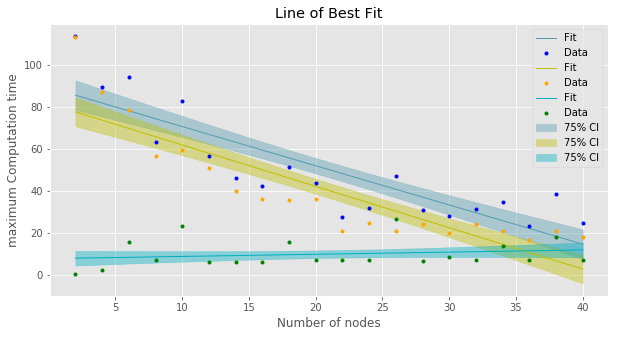

In [19]:
# Perform linear regression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
import pandas as pd
import math

def draw_plot(implementation, ax, fit_color, points_color):

    compsorted, itsorted = zip(*sorted(implementation, key=lambda x: x[1]))

    x = sm.add_constant(itsorted)
    y = compsorted
    regr = sm.OLS(y, x)
    res = regr.fit()
    # Get fitted values from model to plot
    # alpha is CI or sth.. better look up page where copied this from
    st, data, ss2 = summary_table(res, alpha=0.25)
    fitted_values = data[:,2]

    # Get the confidence intervals of the model
    predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

    # Data for regions where we want to shade to indicate the intervals has
    # to be sorted by the x axis to display correctly
    CI_df = pd.DataFrame(columns = ['x_data', 'low_CI', 'upper_CI'])
    CI_df['x_data'] = itsorted
    CI_df['low_CI'] = predict_mean_ci_low
    CI_df['upper_CI'] = predict_mean_ci_upp
    CI_df.sort_values('x_data', inplace = True)

    # Define a function for the line plot with intervals
    def lineplotCI(x_data, y_data, sorted_x, low_CI, upper_CI, x_label, y_label, title):
        # Create the plot object

        # Plot the data, set the linewidth, color and transparency of the
        # line, provide a label for the legend
        ax.plot(x_data, y_data, lw = 1, color = fit_color, alpha = 1, label = 'Fit')
        # Shade the confidence interval
        ax.fill_between(sorted_x, low_CI, upper_CI, color = fit_color, alpha = 0.4, label = '75% CI')
        ax.plot(x_data, compsorted, lw=0, color = points_color, alpha = 1, label = 'Data', marker='.')
        # Label the axes and provide a title
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        # Display legend
        ax.legend(loc = 'best')
        return ax

    # Call the function to create plot
    ax = lineplotCI(x_data = itsorted
               , y_data = fitted_values
               , sorted_x = CI_df['x_data']
               , low_CI = CI_df['low_CI']
               , upper_CI = CI_df['upper_CI']
               , x_label = 'Number of nodes'
               , y_label = 'maximum Computation time'
               , title = 'Line of Best Fit')

_, ax = plt.subplots(figsize=(10, 5))

# CI might not be so important here (we have nothing with which the CI could overlap)

# sum up cpT and mpiT
tot = cp+mpi
# zip together with x-axis (after which we will sort)
totData = zip(tot, x)
# plot
draw_plot(totData, ax, '#539caf', 'b')

# only cp
cpData = zip(cp, x)
draw_plot(cpData, ax, 'y', 'orange')

# only mpi
mpiData = zip(mpi, x)
draw_plot(mpiData, ax, '#00afc2', 'g')